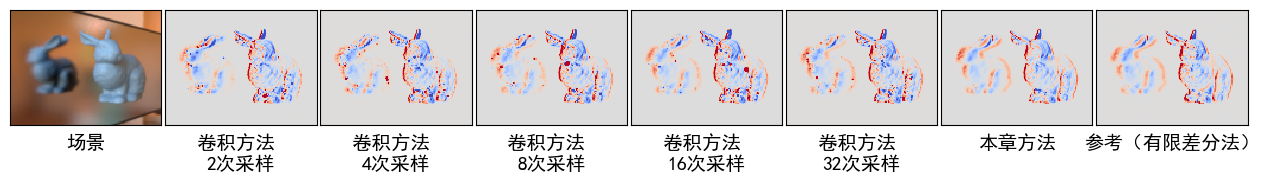

In [7]:
%reload_ext autoreload
%autoreload 2

import sys,os
sys.path.append(os.path.abspath('../'))
from common import *
import configs

matplotlib.rcParams['text.usetex'] = False
matplotlib.rcParams['font.sans-serif'] = ['SimHei']  # 指定默认字体为黑体

import json

fig_name = 'forwardgrads'
fig_dir = join(FIGURE_DIR, fig_name)
used_configs = [configs.ConvolutionWarp2(), configs.ConvolutionWarp4(),
                configs.ConvolutionWarp8(), configs.ConvolutionWarp16(),
                configs.ConvolutionWarp32(), configs.Warp(), configs.FiniteDifferences()]

scenes = ['plane_area',  'glossy_plane']
sdfs = ['shadowing_128',  'bunny_128']
names_pretty = ['Shadowing',  'Bunny']
params = ['x', 'x', 'x']
exposures = [0, 0, 0.5]
w = 128
h = 128
crop_t = 15
crop_b = 15

arrows = [
    (0.95, 0.5, -0.1, 0.0),
    (0.9, 0.18, -0.07, 0.07),
    (0.49, 0.47, -0.07, 0.02)
]

# Timings in forward mode aren't representative, so we don't plot them by default
plot_times = False
aspect = w / h
fontsize = 14
base_size = 2
n_rows = len(scenes)
n_cols = len(params) * len(used_configs) + 1
fig = plt.figure(1, figsize=(n_cols * base_size * aspect, n_rows * base_size * 0.78), constrained_layout=False)
gs = fig.add_gridspec(n_rows, n_cols, wspace=0.025, hspace=0.025)
names = ['卷积方法 \n2次采样', '卷积方法 \n4次采样', '卷积方法 \n8次采样',
         '卷积方法 \n16次采样', '卷积方法 \n32次采样', '本章方法', '参考（有限差分法）']
y_offset = -0.14
for row, (scene, sdf, param, exposure) in enumerate(zip(scenes, sdfs, params, exposures)):
    sdf = sdf.split('_')[0]
    ax = fig.add_subplot(gs[row, 0])
    img = read_img(join(fig_dir, f'{sdf}.exr'), exposure=exposure)
    img = img[crop_t:-crop_b, :, :]
    img = np.repeat(np.repeat(img, 4, axis=1), 4, axis=0)
    aspect = img.shape[0] / img.shape[1]
    ax.imshow(img, interpolation='none', extent=[0, 1, 0, aspect])
    disable_ticks(ax)
    #ax.set_ylabel('\\textsc{' + names_pretty[row] + '}', labelpad=5)
    ax.yaxis.set_label_position("left")
    if row == n_rows - 1:
        txt = ax.set_title('场景', fontsize=fontsize, y=y_offset, va='top')
    col = 1
    r = None
    for cfg_idx, cfg in enumerate(used_configs):
        if type(cfg) is configs.FiniteDifferences:
            cfg.pretty_name_short = 'Reference'

        ax = fig.add_subplot(gs[row, col])
        fn = join(fig_dir, f'{sdf}_{cfg.name}_{param}.exr')
        img = read_img(fn, 5, False)
        img = img[crop_t:-crop_b, :, :]
        img = np.mean(img, axis=-1)
        if r is None:
            r = np.quantile(np.abs(img), 0.99)
            r = np.maximum(r, 1)

        img = np.repeat(np.repeat(img, 4, axis=1), 4, axis=0)
        aspect = img.shape[0] / img.shape[1]
        ax.imshow(img, vmin=-r, vmax=r, cmap='coolwarm_r', extent=[0, 1, 0, aspect], interpolation='none')
        disable_ticks(ax)
        if row == n_rows - 1 and col > 0:
            txt = ax.set_title(names[col - 1], fontsize=fontsize, y=y_offset, va='top')

        if not type(cfg) is configs.FiniteDifferences and plot_times:
            with open(join(fig_dir, f'{sdf}_{cfg.name}_{param}.json'), 'r') as f:
                stats = json.load(f)
            duration = stats['total_time'] / 1000
            txt = ax.text(0.99, 0.0, f"{duration:.2f} s", size=14, ha="right", va="bottom")
            txt.set_path_effects([path_effects.withStroke(linewidth=1.0, foreground='white')])
        col += 1
        # if cfg_idx == 1:
        #     ax.arrow(arrows[row][0], arrows[row][1], arrows[row][2], arrows[row][3], lw=0.75,
        #              head_width=0.03, edgecolor='k', facecolor='k', overhang=0.1)
plt.margins(0, 0)
# save_fig(fig_name)
